In [177]:
import torch
import csv

import torch.nn as nn
import numpy as np

from torch.nn import Linear, MSELoss, L1Loss
from torch import optim

In [76]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# Changing the size to (11,1)
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [258]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")

In [33]:
linear_model = Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c
)

Epoch 1, Training loss 258.0821, Validation loss 532.0313
Epoch 1000, Training loss 3.6552, Validation loss 5.4122
Epoch 2000, Training loss 3.0250, Validation loss 3.7810
Epoch 3000, Training loss 3.0125, Validation loss 3.5772


In [34]:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[5.1959]], requires_grad=True)
Parameter containing:
tensor([-16.7488], requires_grad=True)


### Defining Neural Network using PyTorch

In [39]:
seq_model = nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)   
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [40]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

#### Naming the module

In [45]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)


0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [47]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_layer', nn.Linear(1,13)),
    ('activation_layer', nn.Tanh()),
    ('output_layer', nn.Linear(13,1))
]))

In [49]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_layer.weight torch.Size([13, 1])
hidden_layer.bias torch.Size([13])
output_layer.weight torch.Size([1, 13])
output_layer.bias torch.Size([1])


In [50]:
seq_model.output_layer.bias

Parameter containing:
tensor([-0.1758], requires_grad=True)

In [77]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c
)
print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_layer.weight.grad)

Epoch 1, Training loss 2.1242, Validation loss 4.7188
Epoch 1000, Training loss 2.0566, Validation loss 4.1852
Epoch 2000, Training loss 2.0533, Validation loss 4.1278
Epoch 3000, Training loss 2.0507, Validation loss 4.1628
Epoch 4000, Training loss 2.0481, Validation loss 4.2302
Epoch 5000, Training loss 2.0456, Validation loss 4.3113
output tensor([[20.3231],
        [-1.1426]], grad_fn=<AddmmBackward>)
answer tensor([[21.],
        [-4.]])
hidden tensor([[ 0.0004],
        [ 0.0078],
        [-0.0079],
        [-0.0071],
        [ 0.0063],
        [ 0.0009],
        [-0.0005],
        [-0.0073],
        [-0.0004],
        [-0.0032],
        [-0.0072],
        [-0.0074],
        [-0.0014]])


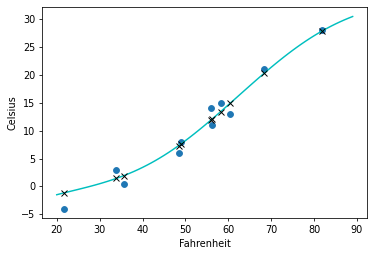

In [78]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=70)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

### Exercise

**Exercise one** 
        
    Experiment with the number of hidden neurons in our simple neural network
    model, as well as the learning rate.
        a. What changes result in more linear output from the model?
            1. Chaning the activation is giving a Linear output

        b. Can you get the model to obviously overfit the data?
            1. Increasing the number of epoch will overfit the model
            2. Making the Network more complex by adding either new neuron or new hidden layers

In [173]:
seq_model_relu = nn.Sequential(
    nn.Linear(1,13),
    nn.ReLU(),
    nn.Linear(13,1),
)
seq_model_relu

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): ReLU()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [174]:
optimizer = optim.Adam(seq_model_relu.parameters(), lr=1e-2)
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=seq_model_relu,
    loss_fn=nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c
)

Epoch 1, Training loss 148.7407, Validation loss 200.9775
Epoch 1000, Training loss 2.4152, Validation loss 2.0957
Epoch 2000, Training loss 2.0468, Validation loss 1.0172
Epoch 3000, Training loss 1.9815, Validation loss 2.3629


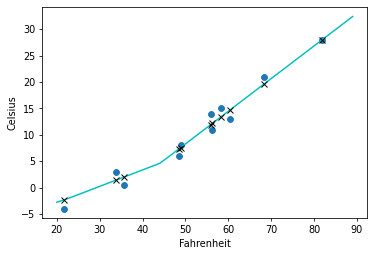

In [175]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=70)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model_relu(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model_relu(0.1 * t_u).detach().numpy(), 'kx')

**Exercise Two**

    The third-hardest problem in physics is finding a proper wine to celebrate discoveries.
    Load the wine data from chapter 4, and create a new model with the appropriate number
    of input parameters.
    
    a. How long does it take to train compared to the temperature data we have
    been using?
        A Little more than the previous example as there were 3919 sample examples and 11 features.
        Since I also added one more hidden layer the time was increased due to backpropogation.
        
    b. Can you explain what factors contribute to the training times?
        Features, Hidden Layers, and Number of training examples
    
    c. Can you get the loss to decrease while training on this dataset?
        Not really.
    
    d. How would you go about graphing this dataset?
    

In [250]:
wine_path = "F:/Study/Dataset/PyTorch/dlwpt-code-master/data/p1ch4/tabular-wine/winequality-white.csv"

wine_data = np.loadtxt(wine_path, delimiter=';', skiprows=1, dtype=np.float32)

col_list = next(csv.reader(open(wine_path), delimiter=';'))

wine_tensor = torch.from_numpy(wine_data)

# Seperate data and target
data = wine_tensor[:,:-1]
target = wine_tensor[:, -1].float()
target = target.unsqueeze(1)

In [251]:
n_samples = data.shape[0]
n_idx = int(0.2 * n_samples)

shuffled_index = torch.randperm(n_samples)

train_indices = shuffled_index[:-n_idx]
valid_indices = shuffled_index[-n_idx:]

X_train = data[train_indices]
y_train = target[train_indices]

X_valid = data[valid_indices]
y_valid = target[valid_indices]

In [252]:
# X_train.shape
X_valid.shape

torch.Size([979, 11])

In [267]:
wine_model = nn.Sequential(
    nn.Linear(11, 20),
    nn.ReLU(),
    nn.Linear(20,10),
    nn.ReLU(),
    nn.Linear(10,1)
)
wine_model

Sequential(
  (0): Linear(in_features=11, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [268]:
optimizer = optim.Adam(wine_model.parameters(), lr=1e-2)

In [279]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=wine_model,
    loss_fn=nn.L1Loss(),
    t_u_train = X_train,
    t_u_val = X_valid,
    t_c_train = y_train,
    t_c_val = y_valid
)

Epoch 1, Training loss 0.5685, Validation loss 0.5882
Epoch 1000, Training loss 0.5656, Validation loss 0.5842
Epoch 2000, Training loss 0.5666, Validation loss 0.5882
Epoch 3000, Training loss 0.5640, Validation loss 0.5827
